In [1]:
import numpy as np
import matplotlib.pyplot as plt
from util import *

In [2]:
CHANNEL_MAPPING = {
    3: '16-QAM',
    84: 'PM-QPSK',
    52: '8-QAM',
    74: '8-QAM'
}

INVERSE_CHANNEL_MAPPING = {
    '16-QAM': 3,
    '8-QAM': [52, 74],
    'PM-QPSK': 84
}

CHANNEL_COLORS = {
    '16-QAM': 'cornflowerblue',
    '8-QAM': 'orangered',
    'PM-QPSK': 'teal'
}

directory = 'mod_formats'

In [3]:
timestamps, bers, fecs, powers = parse_transponder_data(f'../data/{directory}/transponder_data.csv')

In [4]:
postproc_bers = {}
postproc_fecs = {}
postproc_powers = {}

for mod_format, channels in INVERSE_CHANNEL_MAPPING.items():
    if type(channels) == list:
        postproc_bers[mod_format] = np.mean([bers[channel] for channel in channels], axis=0)
        postproc_fecs[mod_format] = np.mean([fecs[channel] for channel in channels], axis=0)
        postproc_powers[mod_format] = np.mean([powers[channel] for channel in channels], axis=0)
    else:
        postproc_bers[mod_format] = bers[channels]
        postproc_fecs[mod_format] = fecs[channels]
        postproc_powers[mod_format] = powers[channels]

In [5]:
min_ts = min(timestamps)
ts_adjusted = [ts - min_ts for ts in timestamps]

In [6]:
first_fec_change = {}
for wavelength, fec_vals in postproc_fecs.items():
    initial_fec = fec_vals[0]
    for i in range(1, len(fec_vals)):
        if fec_vals[i] > initial_fec:
            first_fec_change[wavelength] = i
            break

In [7]:
first_fec_change_stop = {}

for wavelength, fec_vals in postproc_fecs.items():
    for i in range(first_fec_change[wavelength], len(fec_vals) - 5):
        if all(fec_vals[i] == fec_vals[i+j] for j in range(1, 6)):
            first_fec_change_stop[wavelength] = i
            break

In [8]:
layer3_times, layer3_vals = get_layer3_data(directory)

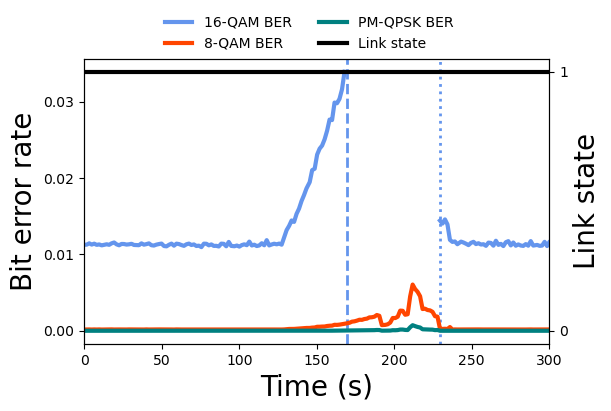

In [9]:
fig, ax = plt.subplots(figsize=(6,3.7))
ax2 = ax.twinx()

ax2.plot([layer3_time - min_ts for layer3_time in layer3_times], layer3_vals, color='black', label='Link state', lw=3)
for mod_format, vals in postproc_bers.items():
    # Between stable FEC values when the uncorrectable FEC counter is increasing, i.e., the link is failing, the hardware is unable to accurately calculate a BER, so we do not plot any data for this period
    ax.plot(ts_adjusted, [vals[i] if i < first_fec_change[mod_format] or i >= first_fec_change_stop[mod_format] else None for i in range(0, len(vals))], color=CHANNEL_COLORS[mod_format], label=mod_format + ' BER', lw=3)
    ax.axvline(x=ts_adjusted[first_fec_change[mod_format]], color=CHANNEL_COLORS[mod_format], linestyle='dashed', lw=2)
    ax.axvline(x=ts_adjusted[first_fec_change_stop[mod_format]], color=CHANNEL_COLORS[mod_format], linestyle='dotted', lw=2)

ax.set_xlabel('Time (s)', fontsize=20)
ax2.set_yticks([0,1])
ax.set_yticks([0, 0.01, 0.02, 0.03])
ax.set_ylabel('Bit error rate', fontsize=20)
ax2.set_ylabel('Link state', fontsize=20)

ax.set_xlim(0, 300)  # We did a random experiment with the variable optical after the bend experiments (post 300 s) -- we don't care about this data
fig.legend(bbox_to_anchor=(0.5, 0.95), loc='center', ncol=2, frameon=False)

plt.rcParams.update({'font.size': 14})
plt.show()